In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms


import umap
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

import os
from PIL import Image, ImageOps

c:\Users\brakp\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

class DigitCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(128 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


In [3]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)


from torch.utils.data import DataLoader

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:07<00:00, 1.34MB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 248kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:02<00:00, 702kB/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.46MB/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [4]:
model = DigitCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print("Using device:", device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 20
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1} loss: {running_loss/len(trainloader):.4f}")


Using device: cuda
Epoch 1 loss: 0.1855
Epoch 2 loss: 0.0850
Epoch 3 loss: 0.0697
Epoch 4 loss: 0.0589
Epoch 5 loss: 0.0511
Epoch 6 loss: 0.0467
Epoch 7 loss: 0.0452
Epoch 8 loss: 0.0418
Epoch 9 loss: 0.0389
Epoch 10 loss: 0.0355
Epoch 11 loss: 0.0355
Epoch 12 loss: 0.0310
Epoch 13 loss: 0.0317
Epoch 14 loss: 0.0309
Epoch 15 loss: 0.0293
Epoch 16 loss: 0.0282
Epoch 17 loss: 0.0288
Epoch 18 loss: 0.0275
Epoch 19 loss: 0.0268
Epoch 20 loss: 0.0269


In [5]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")


Accuracy on test set: 99.40%


c:\Users\brakp\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


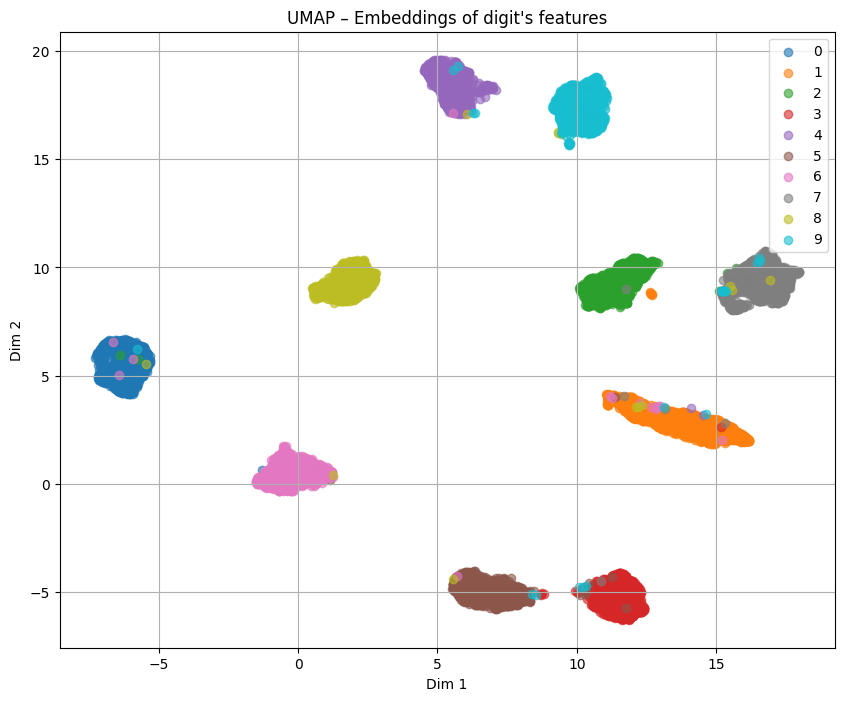

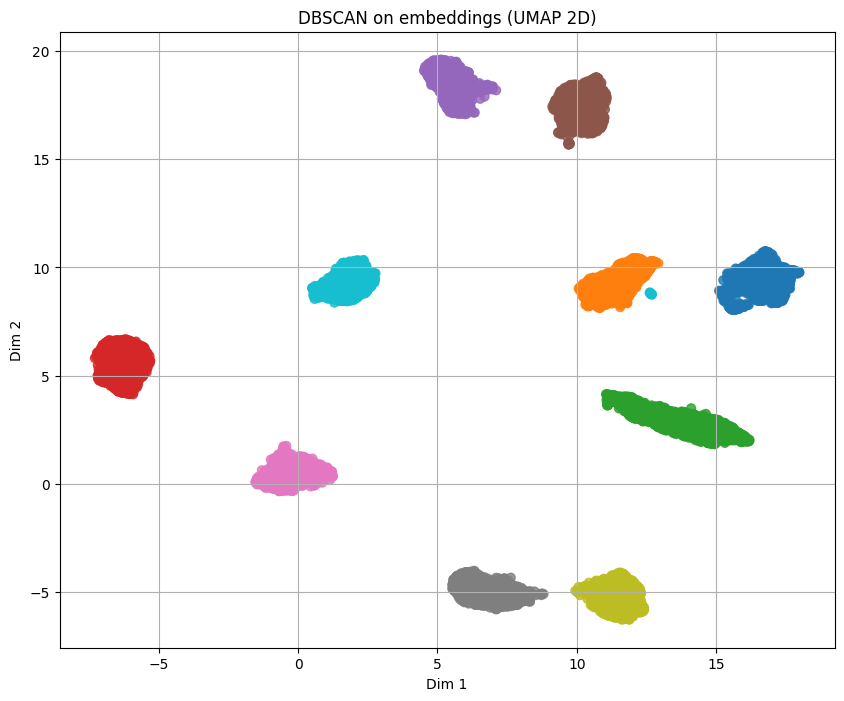

In [6]:
all_images = []
all_labels = []

for images, labels in testloader:
    all_images.append(images)
    all_labels.append(labels)


all_images = torch.cat(all_images).to(device)
all_labels = torch.cat(all_labels).cpu().numpy()


model.eval()
with torch.no_grad():
    feature_maps = model.features(all_images)
    embeddings = feature_maps.view(feature_maps.size(0), -1).cpu().numpy()


reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
for i in range(10):
    idx = all_labels == i
    plt.scatter(embedding_2d[idx, 0], embedding_2d[idx, 1], label=str(i), alpha=0.6)
plt.legend()
plt.title("UMAP – Embeddings of digit's features")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()

dbscan = DBSCAN(eps=0.5, min_samples=5)
cluster_labels = dbscan.fit_predict(embedding_2d)

plt.figure(figsize=(10, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=cluster_labels, cmap="tab10", s=40, alpha=0.8)
plt.title("DBSCAN on embeddings (UMAP 2D)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_transform = transforms.Compose([
    transforms.Lambda(lambda img: ImageOps.invert(img)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

data_dir = "custom_test_data"

model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for label_str in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_str)
        if not os.path.isdir(label_path):
            continue
        label = int(label_str)
        for file_name in os.listdir(label_path):
            if not file_name.endswith('.png'):
                continue
            img_path = os.path.join(label_path, file_name)
            img = Image.open(img_path).convert('L')

            img = test_transform(img).unsqueeze(0).to(device)

            outputs = model(img)
            _, predicted = torch.max(outputs, 1)
            pred_label = predicted.item()

            print(f"File: {img_path}, Correct: {label}, Prediction: {pred_label}")

            total += 1
            if pred_label == label:
                correct += 1

    print(f"Accuracy on custom test set: {100 * correct / total:.2f}%")


File: custom_test_data\0\0.1.png, Correct: 0, Prediction: 0
File: custom_test_data\0\0.2.png, Correct: 0, Prediction: 0
File: custom_test_data\0\0.3.png, Correct: 0, Prediction: 0
File: custom_test_data\0\0.4.png, Correct: 0, Prediction: 0
File: custom_test_data\0\0.5.png, Correct: 0, Prediction: 0
File: custom_test_data\1\1.1.png, Correct: 1, Prediction: 7
File: custom_test_data\1\1.2.png, Correct: 1, Prediction: 1
File: custom_test_data\1\1.3.png, Correct: 1, Prediction: 1
File: custom_test_data\1\1.4.png, Correct: 1, Prediction: 1
File: custom_test_data\1\1.5.png, Correct: 1, Prediction: 1
File: custom_test_data\2\2.1.png, Correct: 2, Prediction: 2
File: custom_test_data\2\2.2.png, Correct: 2, Prediction: 2
File: custom_test_data\2\2.3.png, Correct: 2, Prediction: 2
File: custom_test_data\2\2.4.png, Correct: 2, Prediction: 2
File: custom_test_data\2\2.5.png, Correct: 2, Prediction: 2
File: custom_test_data\3\3.1.png, Correct: 3, Prediction: 3
File: custom_test_data\3\3.2.png, Correc

In [8]:
torch.save(model.state_dict(), "model.pth")